In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from rdkit.Chem import Descriptors
from rdkit import Chem

# Preprocessing + PCA

In [2]:
# Read file
original_df = pd.read_csv('tested_molecules_1.csv')

# Split the column
original_df[['SMILES', 'ALDH1_inhibition']] = original_df['SMILES,"ALDH1_inhibition"'].str.split(',', expand=True)
original_df.drop('SMILES,"ALDH1_inhibition"', axis=1, inplace=True)

original_df['ALDH1_inhibition'] = original_df['ALDH1_inhibition'].str.strip('"')

all_descriptors = [desc[0] for desc in Descriptors.descList]

descriptor_data = []
for i, row in original_df.iterrows():
    mol = Chem.MolFromSmiles(row['SMILES'])
    descriptor_values = [getattr(Descriptors, descriptor)(mol) for descriptor in all_descriptors]
    descriptor_data.append(descriptor_values)

descriptor_df = pd.DataFrame(descriptor_data, columns=all_descriptors)
original_df = pd.concat([original_df, descriptor_df], axis=1)

df = original_df.copy()

# The same needs to be done for the test_data

original_df_test = pd.read_csv('tested_molecules_2.csv')

original_df_test[['SMILES', 'ALDH1_inhibition']] = original_df_test['SMILES;ALDH1_inhibition'].str.split(';', expand=True)
original_df_test.drop('SMILES;ALDH1_inhibition', axis=1, inplace=True)

#original_df_test['ALDH1_inhibition'] = original_df['ALDH1_inhibition'].str.strip('"')
X_test_data = original_df_test.copy()

df_variables = df.drop(columns=["SMILES"]) 
df_variables['ALDH1_inhibition'] = pd.to_numeric(df_variables['ALDH1_inhibition'])

# Remove values that do not vary 
df_for_stv_variables = df_variables.copy()

# Calculate the standard deviation for each column
std_dev = df_for_stv_variables.std()
threshold = 0.1

columns_to_drop = std_dev[std_dev < threshold].index

# Drop the columns with zero standard deviation from df_variables
df_for_stv_variables.drop(columns=columns_to_drop, inplace=True)

# Correlation >0.9 removed.                         # Van 180 naar 146
new_df_variables = df_for_stv_variables.copy()
corr_matrix = new_df_variables.corr().abs()
corr_matrix
mask = np.triu(np.ones(corr_matrix.shape, dtype=bool), k=1)
mask

# Select upper triangle of correlation matrix using the boolean mask
upper = corr_matrix.where(mask)

# Find index of columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

# Drop the columns
new_df_variables.drop(columns=to_drop, inplace=True)

 # Sort on correlation with Inhibition.   
    
first_column = new_df_variables.iloc[:, 0]                           # Select the first column ,is ALDH1_inhibition
correlations = new_df_variables.iloc[:, 1:].corrwith(first_column)
sorted_correlations = correlations.abs().sort_values(ascending=False)

df_filtered = new_df_variables.copy()
a = 0
for column_name, correlation in sorted_correlations.items():
    # print("Column:", column_name)
    # print("Absolute Correlation:", correlation)
    # print()
 
    if correlation < 0.08:
        a = a + 1
        df_filtered = df_filtered.drop(columns=[column_name]) 
df_filtered = df_filtered.drop(columns=['ALDH1_inhibition']) 
df_selected = df_filtered.copy()
# Scaling the data 
df_copied = df_selected.copy()
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_copied)

# Create principal components
pca = PCA()
df_pca = pca.fit_transform(df_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(df_pca.shape[1])]
df_pca_converted = pd.DataFrame(df_pca, columns=component_names)

# kNN algorithm

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [4]:
X = df_pca_converted
y = original_df_test['ALDH1_inhibition']
neighbours = range(1,67)
scores_list = []
std_list = []
for i in neighbours:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=32)
    ## Instantiate the model with 5 neighbors. 
    knn = KNeighborsClassifier(n_neighbors=i)
    ## Fit the model on the training data.
    knn.fit(X_train, y_train)
    ## See how the model performs on the test data.
    score = knn.score(X_test, y_test) #mean accuracy
    std_list.append(np.std(knn.predict_proba(X_test)))
    scores_list.append(score)

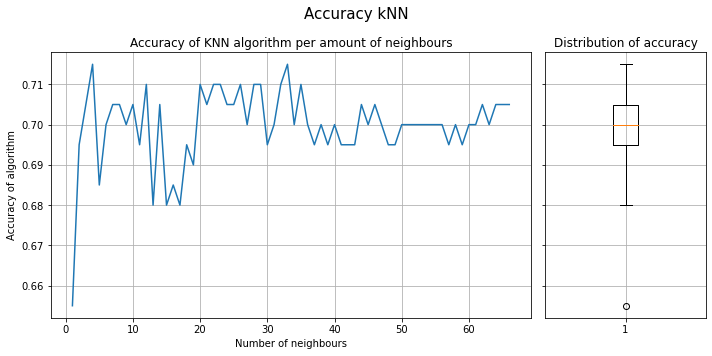

In [5]:
fig, ax = plt.subplots(1,2,figsize=(10,5),sharey=True, gridspec_kw={'width_ratios': [3, 1]})
plt.suptitle('Accuracy kNN',size=15)

ax[0].plot(neighbours,scores_list)
ax[0].set_title('Accuracy of KNN algorithm per amount of neighbours')
ax[0].set_xlabel('Number of neighbours')
ax[0].set_ylabel('Accuracy of algorithm')
ax[0].grid()

ax[1].boxplot(scores_list)
ax[1].set_title('Distribution of accuracy')
ax[1].grid()
plt.tight_layout()

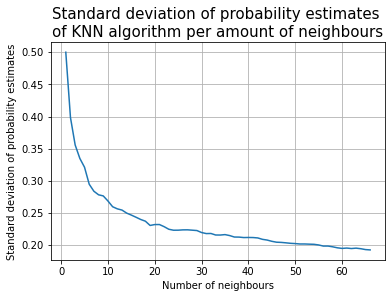

In [6]:
plt.plot(neighbours,std_list)
plt.title('Standard deviation of probability estimates \nof KNN algorithm per amount of neighbours',size=15)
plt.xlabel('Number of neighbours')
plt.ylabel('Standard deviation of probability estimates')
plt.grid()

# Support vector clustering

In [7]:
from sklearn.svm import SVC

In [8]:
svc_scores_list = []

for i in range(1,100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=i)
    svc = SVC()
    svc.fit(X_train, y_train)
    svc_scores_list.append(svc.score(X_test,y_test))

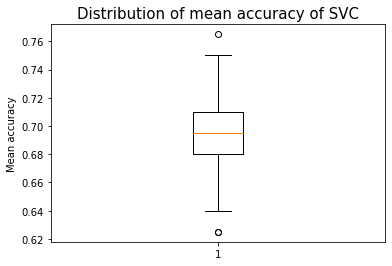

In [9]:
plt.boxplot(svc_scores_list);
plt.title('Distribution of mean accuracy of SVC',size=15);
plt.ylabel('Mean accuracy');